In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set working directory equal to location of current notebook file
os.getcwd()
working_directory = os.path.dirname(os.path.abspath(__vsc_ipynb_file__))
os.chdir(working_directory)
os.getcwd()

'/home/rory/Dev/AIML/practice/deep-learning-with-pytorch'

In [3]:
# Convert mnist image files into tensor of 4 dimensions (# of images, height, width, and color channel)
transform = transforms.ToTensor()

In [4]:
# Get train data
train_data = datasets.MNIST(root=rf'./input/cnn_data', train=True, download=True, transform=transform)

In [5]:
# Get test data
test_data = datasets.MNIST(root=rf'./input/cnn_data', train=False, download=True, transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./input/cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./input/cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
# Create a small batch size for images ... let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(train_data, batch_size=10, shuffle=False)

In [9]:
# Define our CNN Model
# Describe convolutional layer and what it's doing (2 conv layers)
# This is just an example
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [10]:
# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
    break

In [11]:
X_train.shape

torch.Size([1, 28, 28])

In [12]:
x = X_train.view(1,1,28,28)

In [13]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified linear unit for our activation function

In [14]:
x

tensor([[[[0.3314, 0.3314, 0.3314,  ..., 0.3314, 0.3314, 0.3314],
          [0.3314, 0.3314, 0.3314,  ..., 0.3314, 0.3314, 0.3314],
          [0.3314, 0.3314, 0.3314,  ..., 0.3314, 0.3314, 0.3314],
          ...,
          [0.3314, 0.3314, 0.4668,  ..., 0.3314, 0.3314, 0.3314],
          [0.3314, 0.3314, 0.4386,  ..., 0.3314, 0.3314, 0.3314],
          [0.3314, 0.3314, 0.3314,  ..., 0.3314, 0.3314, 0.3314]],

         [[0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745],
          [0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745],
          [0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745],
          ...,
          [0.2745, 0.2745, 0.3304,  ..., 0.2745, 0.2745, 0.2745],
          [0.2745, 0.2745, 0.3710,  ..., 0.2745, 0.2745, 0.2745],
          [0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745]],

         [[0.1076, 0.1076, 0.1076,  ..., 0.1076, 0.1076, 0.1076],
          [0.1076, 0.1076, 0.1076,  ..., 0.1076, 0.1076, 0.1076],
          [0.1076, 0.1076, 0.1076,  ..., 0

In [15]:
# 1 single image, 6 is the filters we asked for, 26x26 is now the image because padding wasn't used and 2 were dropped around the edges
x.shape

torch.Size([1, 6, 26, 26])

In [16]:
# Pass through the pooling layer
x = F.max_pool2d(x,2,2) # Kernel of 2 and stride of 2

In [17]:
x.shape # 25 / 2 = 13

torch.Size([1, 6, 13, 13])

In [18]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [19]:
x.shape # Again, we didn't set padding and we lose 2 pixels around the outside

torch.Size([1, 16, 11, 11])

In [20]:
# Pooling layer
x = F.max_pool2d(x,2,2)

In [21]:
x.shape # 11 / 2 = 5.5 but we have to round down, because we can't invent data to round up

torch.Size([1, 16, 5, 5])

In [22]:
((28-2) / 2 - 2) / 2

5.5

In [23]:
# Model class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        # Fully connected layers
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        # First Pass
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # 2x2 kernel with stride of 2
        # Second Pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2) # 2x2 kernel with stride of 2

        #Re-View to flatten it out
        X = X.view(-1, 16*5*5) # Negative one so that we can vary the batch size

        # Fully Connected Layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [24]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the learning rate, the longer it will take to train... Too big can cause instability

In [26]:
start_time = time.time()

# Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Create a for loop of epochs
for i in range(epochs):
    train_cor = 0
    test_cor = 0
    # Train
    for batch, (X_train, y_train) in enumerate(train_loader):
        batch += 1 # Start our batches at 1
        y_pred = model(X_train) # Get predicted values from the training set. Not flattened... it is 2-D
        loss = criterion(y_pred, y_train) # How off are we? Compare predicted values to actual values

        predicted = torch.max(y_pred.data, 1)[1] # Add up the number of correct prdictions and index off of the first point
        batch_cor = (predicted == y_train).sum() # Sum however many predictions we got correct
        train_cor += batch_cor # Keep track as we go along in training

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out some results
        if batch%600 == 0:
            print(f'Epoch: {i}  Batch: {batch}  Loss: {loss.item()}')
        
    train_losses.append(loss)
    train_correct.append(train_cor)

    # Test
    with torch.no_grad(): # No gradient so that we don't update our weights and biases with our test data
        for batch, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
            test_cor = (predicted == y_test).sum() # Sum however many predictions we got correct
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_cor)

current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.16236244142055511
Epoch: 0  Batch: 1200  Loss: 0.16302061080932617
Epoch: 0  Batch: 1800  Loss: 0.5362371802330017
Epoch: 0  Batch: 2400  Loss: 0.181561678647995
Epoch: 0  Batch: 3000  Loss: 0.006205611862242222
Epoch: 0  Batch: 3600  Loss: 0.33742740750312805
Epoch: 0  Batch: 4200  Loss: 0.005262851249426603
Epoch: 0  Batch: 4800  Loss: 0.0016028400277718902
Epoch: 0  Batch: 5400  Loss: 0.04928583651781082
Epoch: 0  Batch: 6000  Loss: 0.00033870976767502725
Epoch: 1  Batch: 600  Loss: 0.0019276011735200882
Epoch: 1  Batch: 1200  Loss: 0.3193497657775879
Epoch: 1  Batch: 1800  Loss: 0.003310810774564743
Epoch: 1  Batch: 2400  Loss: 0.004682301077991724
Epoch: 1  Batch: 3000  Loss: 0.016263607889413834
Epoch: 1  Batch: 3600  Loss: 0.42812198400497437
Epoch: 1  Batch: 4200  Loss: 0.018768612295389175
Epoch: 1  Batch: 4800  Loss: 0.0009659092756919563
Epoch: 1  Batch: 5400  Loss: 0.00017001254309434444
Epoch: 1  Batch: 6000  Loss: 0.09918522834777832
Epoch: 2

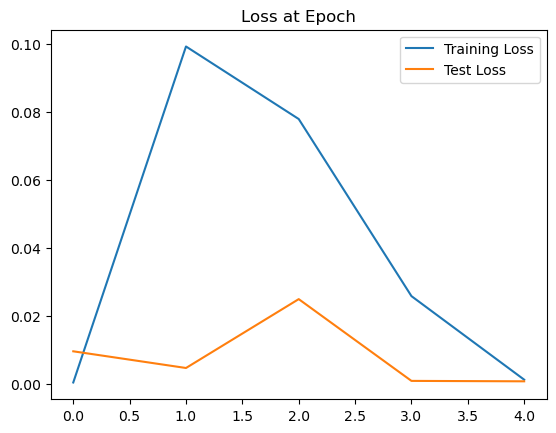

In [27]:
# Graph the loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Test Loss")
plt.title("Loss at Epoch")
plt.legend()

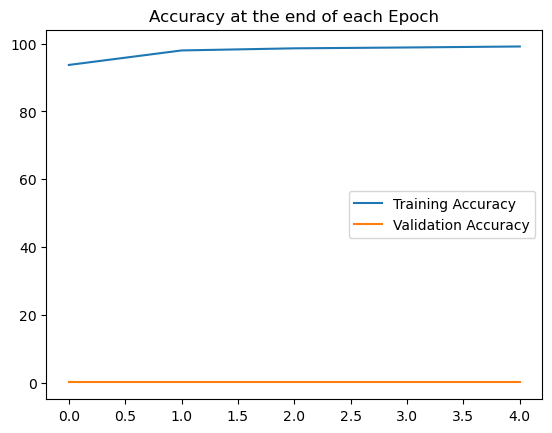

In [28]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [29]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [30]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [31]:
# Did for correct
correct.item()/len(test_data)*100

98.19

In [32]:
# Grab an image
test_data[1978] # Tensor with an image in it... at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [33]:
# Grab just the data
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [34]:
# Reshape it
test_data[1978][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

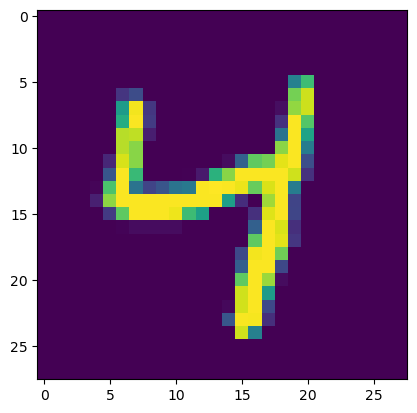

In [35]:
# Show the image
plt.imshow(test_data[1978][0].reshape(28, 28))

In [36]:
# Pass the image through our model
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[1978][0].view(1, 1, 28, 28)) # Batch size of 1, Number color channels = 1, and 28x28 image

In [37]:
# Cheack the new prediction... get probabilities
new_prediction

tensor([[-2.4885e+01, -1.6976e+01, -2.3024e+01, -2.7001e+01, -3.5763e-07,
         -1.6502e+01, -1.8327e+01, -2.0882e+01, -1.9250e+01, -1.5358e+01]])

In [38]:
new_prediction.argmax()

tensor(4)